# 1. 데이터 불러오기 및 라이브러리 설치

In [1]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

#라이브러리 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#시드 설정
random.seed(123)
np.random.seed(123)
os.environ['PYTHONHASHSEED']=str(123)

In [3]:
directory = "SVS" # 파일이 있는 디렉토리
path = "/content/gdrive/My Drive/" + directory
os.chdir(path)

In [4]:
train=pd.read_csv(path+'/final_train.csv')

In [5]:
X = train.drop(['id','target'],axis=1)
y = train.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=123) # stratify = y 를 넣어주어 0과 1의 비율을 맞춤!

In [7]:
# 비율이 맞는지 확인

print(y_train.value_counts()/y_train.shape[0]* 100)
print(y_test.value_counts()/y_test.shape[0]*100)

0.0    96.344972
1.0     3.655028
Name: target, dtype: float64
0.0    96.344654
1.0     3.655346
Name: target, dtype: float64


# 2. 모델링 및 적합

In [8]:
# 모델
model = LGBMClassifier(scale_pos_weight=14,
                       boosting='gbdt', # gradient boosting decision tree
                       learning_rate=0.05,
                       boost_from_average=False, # 불균형한 데이터에 써주는게 성능이 좋음
                       num_iterations=3000,
                       max_depth=10,
                       max_leaves=1023,
                       n_jobs=-1,
                       metric='auc', # 평가요소 - auc
                       objective='binary',
                       feature_fraction=0.7)

evals = [(X_test, y_test)]

# 모델 학습
model.fit(X_train, y_train, early_stopping_rounds=100,eval_set=evals, verbose = 5)

# 모델 적합
y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[5]	valid_0's auc: 0.629984
[10]	valid_0's auc: 0.633553
[15]	valid_0's auc: 0.635686
[20]	valid_0's auc: 0.637326
[25]	valid_0's auc: 0.638159
[30]	valid_0's auc: 0.639182
[35]	valid_0's auc: 0.640032
[40]	valid_0's auc: 0.640686
[45]	valid_0's auc: 0.641204
[50]	valid_0's auc: 0.64203
[55]	valid_0's auc: 0.643126
[60]	valid_0's auc: 0.643226
[65]	valid_0's auc: 0.643484
[70]	valid_0's auc: 0.643826
[75]	valid_0's auc: 0.64425
[80]	valid_0's auc: 0.644985
[85]	valid_0's auc: 0.645452
[90]	valid_0's auc: 0.645883
[95]	valid_0's auc: 0.646069
[100]	valid_0's auc: 0.646302
[105]	valid_0's auc: 0.646339
[110]	valid_0's auc: 0.646262
[115]	valid_0's auc: 0.646575
[120]	valid_0's auc: 0.646288
[125]	valid_0's auc: 0.646497
[130]	valid_0's auc: 0.646584
[135]	valid_0's auc: 0.646422
[140]	valid_0's auc: 0.646424
[145]	valid_0's auc: 0.646218
[150]	valid_0's auc: 0.646371
[155]	valid_0's auc: 0.646405
[160]	valid_0's auc: 0.646297

In [9]:
def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    AUC = roc_auc_score(y_test, y_pred)
    print('정확도:{:.4f}'.format(accuracy))
    print('정밀도:{:.4f}'.format(precision))
    print('재현율:{:.4f}'.format(recall))
    print('F1:{:.4f}'.format(F1))
    print('AUC:{:.4f}'.format(AUC))

# 정확도 확인
get_clf_eval(y_test,y_pred)

정확도:0.9250
정밀도:0.1034
재현율:0.1372
F1:0.5394
AUC:0.5461


# 3. 변수 중요도 확인

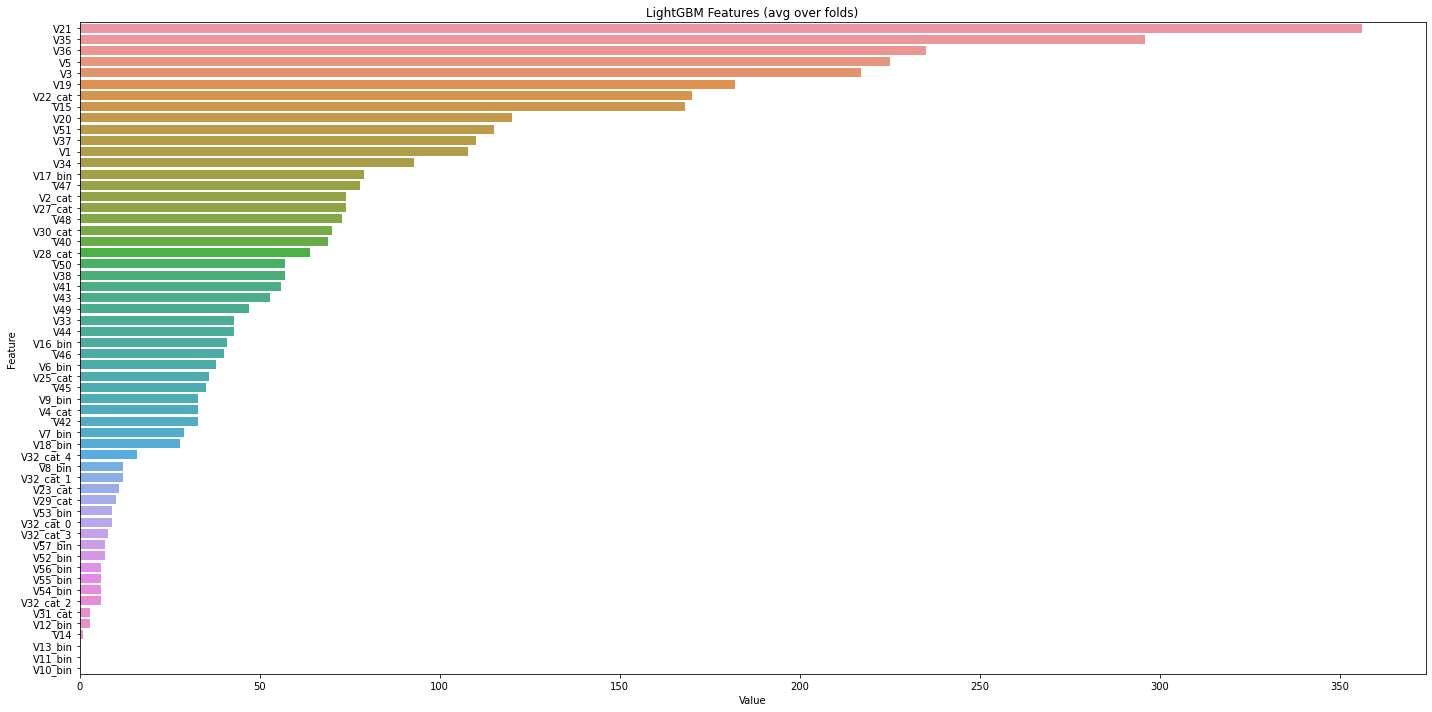

In [10]:
# feature importance 확인

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()